In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Load the dataset
customer_data = pd.read_csv('data/Mall_Customers.csv')

#read the data
customer_data.head()

#check for null or missing values
customer_data.isna().sum()

CustomerID            0
Genre                 0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64

### Let’s look at the data and see how it is distributed:

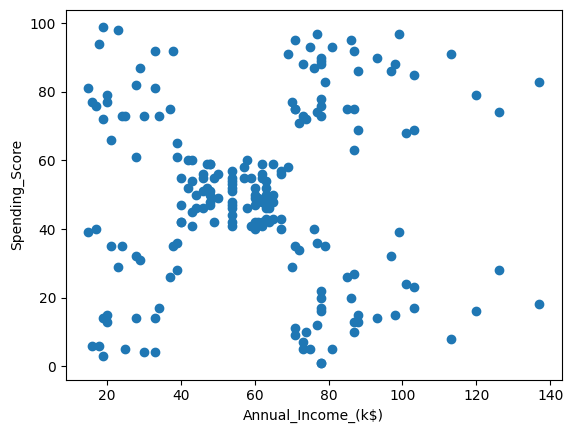

In [3]:
plt.scatter(customer_data['Annual_Income_(k$)'] , customer_data['Spending_Score'] )
plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.show()

#### From the above scatterplot, it is difficult to tell if there is any pattern in the dataset. This is where clustering will help.

First, we will Initialize centroids randomly:

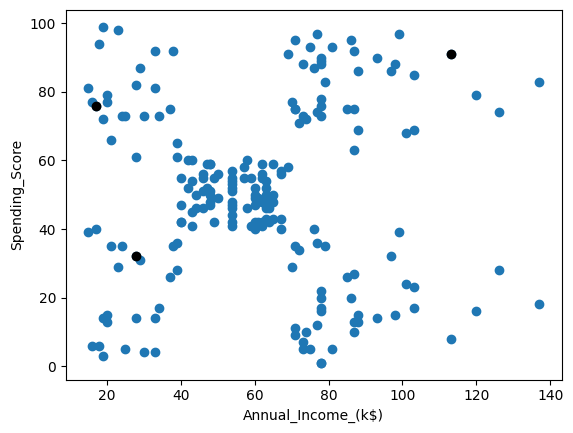

In [7]:
#TODO: RUN IT 10 TIMES TO See  THAT WE WILL HAVE DIFFERENT CENTROIDS
#BECAUSE WE ARE TAKING THE .SAMPLE FUNCTION.
#The sample function provides random values
K=3 # Number of clusters chosen randomly
centroids = customer_data.sample(n=K) #get random k centroids (K clusters -> K centroids, 1 for each cluster)
plt.scatter(customer_data['Annual_Income_(k$)'] , customer_data['Spending_Score'] )
plt.scatter(centroids['Annual_Income_(k$)'] , centroids['Spending_Score'] ,c='black')
plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.show()

In [19]:
centroids
# Centroid (x=Annual Income, y=Spending Score)
# n=K where K=3 -> 3 clusters and 3 centroids
# .sample(n=K) gives random results each time

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score
193,194,Female,38,113,91
26,27,Female,45,28,32
5,6,Female,22,17,76


Next, we will iterate through each centroid and data point, calculate the distance between them, find the K clusters and assign the data points to a significant cluster. This process will continue until the difference between previously defined centroids and current centroids is zero:



#### First let's see the values of Genre


In [8]:
customer_data['Genre'] # Categorical values -> Must be encoded into numerical values inorder to process them

0        Male
1        Male
2      Female
3      Female
4      Female
        ...  
195    Female
196    Female
197      Male
198      Male
199      Male
Name: Genre, Length: 200, dtype: object

As you can see, these are limited to two values only: 

Male and Female
so we need to make them 0 and 1 

#### One hot encoding:
Convert categorical variable into dummy/indicator variables.
![One Hot Encodin](onehotencodingviz.jpg)
## Label Encoding -> Each category is assigned a numerical value
## One Hot Encoding -> Categorical features are transformed into series in a DF, labeled by 1 (Present) and 0 (Abscent)

In [12]:
#one hot encoding to remove Genre values from strings to nuemarical 
customer_data = pd.get_dummies(customer_data, columns=['Genre'], drop_first=True)


In [ ]:
customer_data
# As we can tell, the Genre feature is now encoded, drop_first = True -> first value is true and the other are categorized based on that (Male=True -> First value in the dataset, Female = False)

,CustomerID,Age,Annual_Income_(k$),Spending_Score,Genre_Male
0,1,19,15,39,True
1,2,21,15,81,True
2,3,20,16,6,False
3,4,23,16,77,False
4,5,31,17,40,False
...,...,...,...,...,...
195,196,35,120,79,False
196,197,45,126,28,False
197,198,32,126,74,True
198,199,32,137,18,True


#### Identify Non-Centroids:
This part identifies the data points (customers) that are not currently centroids. customer_data contains all customers, while centroids contains the current centroid points. The mask is used to exclude centroids from the dataset X.

In [ ]:
mask = customer_data['CustomerID'].isin(centroids)   #this mask gets the points that are centroids
print(mask.head())
X = customer_data[~mask] #get all data points that are not centroids
X.head()

0    False
1    False
2    False
3    False
4    False
Name: CustomerID, dtype: bool


,CustomerID,Age,Annual_Income_(k$),Spending_Score,Genre_Male
0,1,19,15,39,True
1,2,21,15,81,True
2,3,20,16,6,False
3,4,23,16,77,False
4,5,31,17,40,False


### Clustering Loop:

In [ ]:
diff = 1 # Looping condition, we stop the algorithm when the centroid doesn't change after calculating the mean value of the data points in its cluster
j=0
XD=X # XD is the DF of non centroid data points
while(diff!=0):
   i=1
   #For each centroid, the Euclidean distance between the centroid and every data point is calculated. 
   # This distance is stored in the DataFrame X.
   for index1,row_c in centroids.iterrows(): # Iterating the centroids DF row by row, and calculating the euclidean distance between data points and centroids
       ED=[]
       for index2,row_d in XD.iterrows():
           #calculate the distance between two points row c and row d for two features annual income and spending score
           d1=( row_c['Annual_Income_(k$)'] - row_d['Annual_Income_(k$)'] )**2 
           d2=( row_c['Spending_Score'] - row_d['Spending_Score'] )**2 
           d=np.sqrt(d1+d2) # Euclidean distance formula
           ED.append(d) # Added the distance into the ED list
       X[i]=ED # Data point i has distance d
       i=i+1 # Used to point to the non centroid data points

   #Assign Clusters
   #Each data point is assigned to the nearest centroid (cluster) by finding the minimum distance.
   C=[] # Clusters list
   for index,row in X.iterrows():
       min_dist=row[1] # We set the minimum distance to be the first
       pos=1
       for i in range(K): # 0,1,2
           if row[i+1] < min_dist: # If the distance between a data point and a centroid is less than the minimum distance, the min distance is modified 
               min_dist = row[i+1]
               pos=i+1
       C.append(pos)
   X["Cluster"]=C # Assigning data points to clusers
   print(X)
   
   #Update Centroids
   #The new centroids are calculated as the mean of the points in each cluster. 
   # If it's the first iteration, diff is set to 1 to ensure the loop continues. 
   # Otherwise, diff is updated based on the change in centroid positions.
   try:
    centroids_new = X.groupby(["Cluster"]).mean()[["Spending_Score","Annual_Income_(k$)"]] # Updating centroids by using the mean value of the data pts in its cluster
   except Exception as e:
       print(f'error : {str(e)}')
       
   #check for convergence
   #The loop continues until the centroids no longer change significantly, indicating that the algorithm has converged.
   if j == 0:
       diff=1
       j=j+1
   else:
       diff = (centroids_new['Spending_Score'] - centroids['Spending_Score']).sum() + (centroids_new['Annual_Income_(k$)'] - centroids['Annual_Income_(k$)']).sum() ## If diff=0, new centroid is the old one, stop the loop
   centroids = X.groupby(["Cluster"]).mean()[["Spending_Score","Annual_Income_(k$)"]]

     CustomerID  Age  Annual_Income_(k$)  Spending_Score  Genre_Male  \
0             1   19                  15              39        True   
1             2   21                  15              81        True   
2             3   20                  16               6       False   
3             4   23                  16              77       False   
4             5   31                  17              40       False   
..          ...  ...                 ...             ...         ...   
195         196   35                 120              79       False   
196         197   45                 126              28       False   
197         198   32                 126              74        True   
198         199   32                 137              18        True   
199         200   30                 137              83        True   

              1           2           3  Cluster  
0    110.941426   14.764823   37.054015        2  
1     98.508883   50.695167    5.

### Now if we will view the dataset and all the data points should be clustered accordingly:



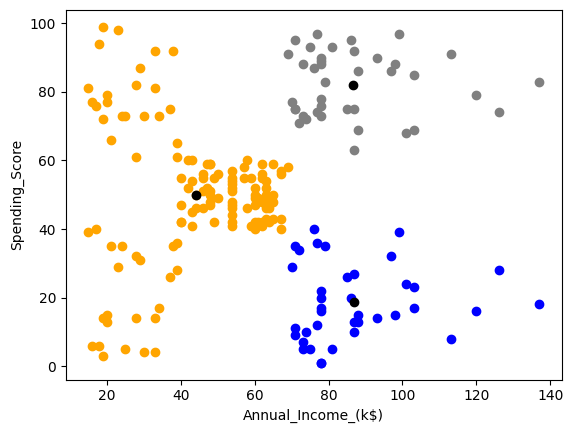

In [22]:
color=['grey','blue','orange']
for k in range(K):
   data=X[X["Cluster"]==k+1]
   plt.scatter(data["Annual_Income_(k$)"],data["Spending_Score"],c=color[k])
plt.scatter(centroids["Annual_Income_(k$)"],centroids["Spending_Score"],c='black')
plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.show()

## Manual implementation is done, we can now make use of the KMeans algorithm in the sklearn library

That was quite a lot of code and the algorithm might also need some optimization to improve its run time. To avoid enhancing the algorithm and writing it all over again, we can use open-source library functions. Scikit Learn has a clustering package that includes a K-means function which is optimized and very popular among researchers.

In [24]:
from sklearn.cluster import  KMeans #import kmeans
km_sample = KMeans(n_clusters= K ) #use if for k = 3, instance of the KMeans
km_sample.fit(customer_data[['Annual_Income_(k$)' , 'Spending_Score' ]]) # we need to give it two features: Annual income and spending

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


<Axes: xlabel='Annual_Income_(k$)', ylabel='Spending_Score'>

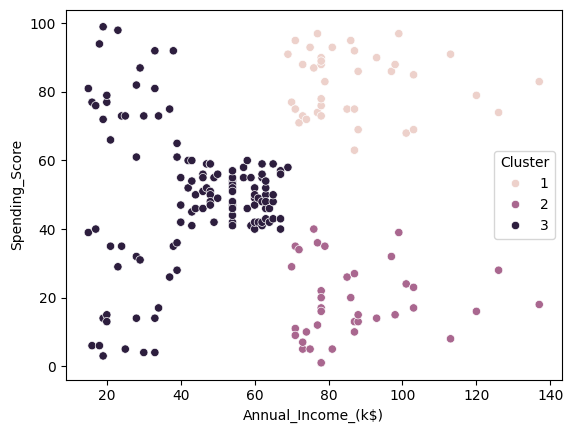

In [25]:
import seaborn as sns #we use sns framework to display the heat map for the results
labels_sample = km_sample.labels_ 
customer_data['label'] = labels_sample
sns.scatterplot(x='Annual_Income_(k$)', y='Spending_Score', hue='Cluster', data=X)


### How to choose K?
Some factors can challenge the efficacy of the final output of the K-means clustering algorithm and one of them is finalizing the number of clusters(K). Selecting a lower number of clusters will result in underfitting while specifying a higher number of clusters can result in overfitting. Unfortunately, there is no definitive way to find the optimal number. 

The optimal number of clusters depends on the similarity measures and the parameters used for clustering. So, to find the number of clusters in the data, we need to run the k-means clustering for a range of values and compare the outcomes. At present, we don’t have any method to determine the exact accurate value of clusters K but we can estimate the value using some techniques, including Cross-validation, Elbow method, Information Criteria, the Silhouette method, and the G-means algorithm. 

## Elbow method

“The elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.” [Resource]( https://en.wikipedia.org/wiki/Elbow_method_(clustering)  )

#### Perform K-means clustering with all the K values. For each K value, we compute the average distance to the centroid across all the data points:

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

#creating sample data
x1 = np.array([3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 7, 8, 9, 8, 9, 9, 8])
x2 = np.array([5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 1, 2, 3, 2, 3])
#Here, two arrays x1 and x2 are defined, representing two features of the data points. 
# These arrays are then combined into a 2D array X using the zip function and reshaped 
# to the appropriate dimensions.
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) # X has len(x1) rows and 2 columns, it's an array of lists, element from x1 is mapped to an element from x2, in a single list using zip
X


array([[3, 5],
       [1, 4],
       [1, 5],
       [2, 6],
       [1, 5],
       [6, 8],
       [6, 6],
       [6, 7],
       [5, 6],
       [6, 7],
       [7, 1],
       [8, 2],
       [9, 1],
       [8, 2],
       [9, 3],
       [9, 2],
       [8, 3]])

In [ ]:
# k means determine k
distortions = [] #it's the cost function value that we need to calculate (of the KMeans algorithm)
K = range(1,10) #test it on 10 iterations
for k in K:
   kmeanModel = KMeans(n_clusters=k) #calculate kmeans 
   kmeanModel.fit(X)
   #The cdist function computes the Euclidean distance between each data point and the cluster centers.
   # The np.min function finds the minimum distance for each point, and the sum of these minimum distances is computed.
   distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [34]:
distortions

[np.float64(3.4577032384495707),
 np.float64(1.7687413573405673),
 np.float64(0.8819889697423957),
 np.float64(0.7993479948778336),
 np.float64(0.6781442108473655),
 np.float64(0.6164273928656036),
 np.float64(0.5241924455825953),
 np.float64(0.42618267462691206),
 np.float64(0.3333333333333333)]

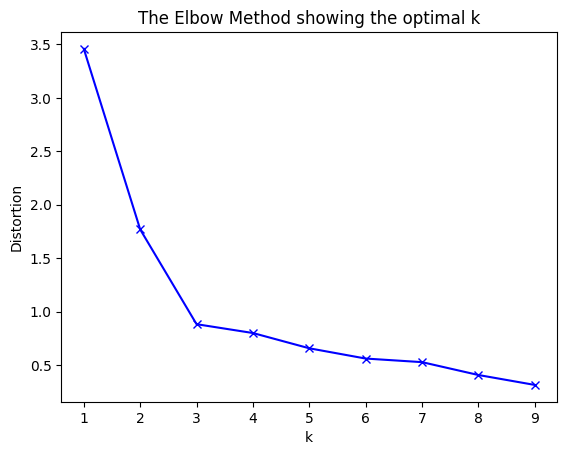

In [ ]:
# Plot the elbow
plt.plot(K, distortions, 'bx-') # bx plots the Xs on the curve
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
## Optimal K = 3 (it is at the elbow)
## If K is very small -> Underfitting
## If K is very large -> Overfitting

### Silhouette method
Finding an Elbow point is challenging in practice but there are other techniques to determine the optimal value of K and one of them is the Silhouette Score method. 

“Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.” [Resource](https://en.wikipedia.org/wiki/Silhouette_(clustering))

### Explanation:
ilhouette coefficient is used to measure the quality of the clusters by checking how similar a data point is within a cluster compared to the other clusters. Silhouette analysis can be used to study the distance between the resulting clusters. This discrete measure ranges between -1 and 1:

+1 indicates that the data point is far away from the neighboring cluster and thus optimally positioned.

0 indicates either it is on or very close to the decision boundary between two neighbor clusters.

-1 indicates that the data point is assigned to the wrong cluster.


To find an optimal value for the number of clusters K, we use a silhouette plot to display a measure of how close each point in one cluster is to a point in the neighboring clusters and thus provide a way to assess parameters like the number of clusters visually. Let’s see how it works.

Compute K-means clustering algorithm for a range of values.
For each value of K, find the average silhouette score of data points:

In [ ]:
# The silhouette score measures how well each data point is placed within its cluster i.e:

#Does this point really belong in this cluster, or is it closer to a different one?

In [37]:
from sklearn.metrics import silhouette_score

sil_avg = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8] # Range for values of K, aka number of clusters, 2 to 8?

for k in range_n_clusters:
 kmeans = KMeans(n_clusters = k).fit(X)
 labels = kmeans.labels_
 sil_avg.append(silhouette_score(X, labels, metric = 'euclidean')) #todo: add other values for metric we can test

Plot the collection of silhouette scores for each value of K

Select the number of clusters when the silhouette score is maximum:

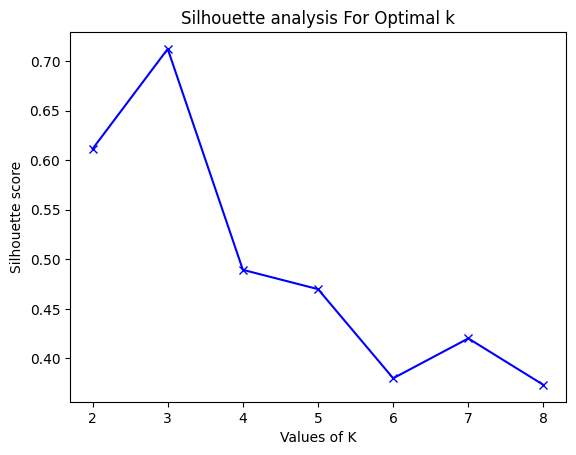

In [38]:
plt.plot(range_n_clusters,sil_avg,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

# the silhouette score was the highest for k=3 -> 3 clusters is the optimal number of clusters

In [39]:

kmeans = KMeans(n_clusters = 3).fit(X)
labels = kmeans.labels_
sil_avg.append(silhouette_score(X, labels, metric = 'euclidean')) #todo: add other values for metric we can test

In [ ]:
import numpy as np

# Define the new data point
new_data_point = np.array([[12,3]])  # Assuming 1 represents 'Male' after one-hot encoding

# Predict the cluster for the new data point
new_data_cluster = kmeans.predict(new_data_point)
print(f'New data point belongs to cluster: {new_data_cluster[0]}')

# Added a new data point at x=12 and y=3, after testing, it belongs to cluster 1
# as expected & predicted by kmeans algo


New data point belongs to cluster: 1
